Here we use a model pretrained on the vanilla dataset and fine-tune it on a cavity dataset with and without noise, and compare its performance with a model trained on these datasets from scratch.

Import external libraries

In [41]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Load cavity datasets

In [42]:
X_train = np.load('..\data\X_train_c.npy')  # population in F=1
Y_train = np.load('..\data\Y_train_c.npy')  #normalized to w_L

X_val = np.load('..\data\X_val_C.npy')  # use validation set for testing
Y_val = np.load('..\data\Y_val_C.npy')  # use validation set for testing

Normalize X data

In [43]:
Level = np.min(X_train)
Height = np.max(X_train) - np.min(X_train)

X_train = (X_train - Level) / Height
X_val = (X_val - Level) / Height

Plot normalized data

Text(0, 0.5, 'DR signal')

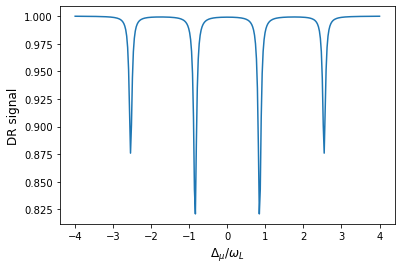

In [44]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-4,4,320), X_train[50])
ax.set_xlabel(r'$\Delta_{\mu}/\omega_{L}$', fontsize=12)
ax.set_ylabel('DR signal', fontsize=12)

Shuffle data sets

In [45]:
m_train = np.random.permutation(len(X_train)) # Shuffling mask for X_train
m_test = np.random.permutation(len(X_val)) # Shuffling mask for X_test

X_train, Y_train = X_train[m_train], Y_train[m_train]
X_val, Y_val = X_val[m_test], Y_val[m_test]

Reshape X for CNN

In [46]:
X_train = X_train[:, :, np.newaxis]
X_val = X_val[:, :, np.newaxis]

Introduce training callbacks

In [47]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_loss', restore_best_weights=True) # Stop if the validation loss is not improving
learning_rate_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100) # Decrease the learning rate if the validation loss is not improving
cb_list = [early_stopping_cb, learning_rate_cb]

# Fine-tuning on cavity data without noise

Load and train the model

In [48]:
model_finetuned_cavity = keras.models.load_model('model_pretrained.h5')
model_finetuned_cavity.compile(loss='mae', optimizer=keras.optimizers.Adam(), metrics=['mae'])

history_finetuned_cavity = model_finetuned_cavity.fit(X_train, Y_train, epochs=2000, validation_data=(X_val, Y_val), batch_size=32, callbacks=cb_list)

Epoch 1/2000
8/8 [==============================] - 1s 57ms/step - loss: 0.0482 - mae: 0.0482 - val_loss: 0.0166 - val_mae: 0.0166 - lr: 0.0010
Epoch 2/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0126 - val_mae: 0.0126 - lr: 0.0010
Epoch 3/2000
8/8 [==============================] - 0s 8ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0131 - val_mae: 0.0131 - lr: 0.0010
Epoch 4/2000
8/8 [==============================] - 0s 9ms/step - loss: 0.0117 - mae: 0.0117 - val_loss: 0.0089 - val_mae: 0.0089 - lr: 0.0010
Epoch 5/2000
8/8 [==============================] - 0s 9ms/step - loss: 0.0085 - mae: 0.0085 - val_loss: 0.0139 - val_mae: 0.0139 - lr: 0.0010
Epoch 6/2000
8/8 [==============================] - 0s 9ms/step - loss: 0.0118 - mae: 0.0118 - val_loss: 0.0081 - val_mae: 0.0081 - lr: 0.0010
Epoch 7/2000
8/8 [==============================] - 0s 9ms/step - loss: 0.0098 - mae: 0.0098 - val_loss: 0.0068 - val_mae: 0.0068 - lr: 0.00

Plot training results

8/8 [==============================] - 0s 13ms/step
max abs error: 0.022620759986406336
mean absolute error: 0.00047727726804435214


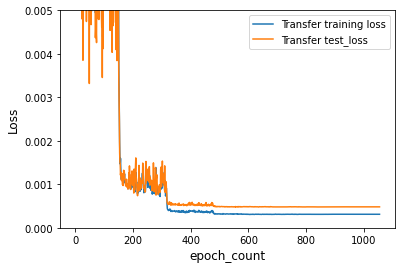

In [49]:
h_finetuned_cavity = history_finetuned_cavity.history

training_data_finetuned_cavity = pd.DataFrame(
    {"Transfer training loss": h_finetuned_cavity["loss"], "Transfer test_loss": h_finetuned_cavity["val_loss"]})
training_data_finetuned_cavity.index.name = 'Transfer Epoch'

fig_finetuned_cavity = training_data_finetuned_cavity.plot()
fig_finetuned_cavity.set_xlabel(r'epoch_count', fontsize=12)
fig_finetuned_cavity.set_ylabel(r'Loss', fontsize=12)
fig_finetuned_cavity.set_ylim(0, 0.005)

y = model_finetuned_cavity.predict(X_val)
print('max abs error:', np.max(np.abs(y - Y_val)))
print('mean absolute error:', np.mean(np.sqrt((y - Y_val) ** 2)))

Save model

In [50]:
model_finetuned_cavity.save('model_finetuned_cavity.h5')

# Training with noise

Add noise to X data

In [51]:
noise_level = 0.005

X_train_N = X_train + np.random.normal(0, noise_level, X_train.shape)
X_val_N = X_val + np.random.normal(0, noise_level, X_val.shape)

## Learning from scratch

In [52]:
model_new = keras.models.Sequential([
    keras.layers.Conv1D(kernel_size=16, activation='relu', padding='SAME', filters=32),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(kernel_size=8, activation='relu', padding='SAME', filters=64),
    keras.layers.Conv1D(kernel_size=8, activation='relu', padding='SAME', filters=64),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(kernel_size=4, activation='relu', padding='SAME', filters=128),
    keras.layers.Conv1D(kernel_size=4, activation='relu', padding='SAME', filters=128),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)
])

model_new.compile(loss="mae", optimizer=keras.optimizers.Adam(), metrics=["mae"])

In [53]:
history_new = model_new.fit(X_train_N, Y_train, epochs=2000, validation_data=(X_val_N, Y_val), batch_size=32, callbacks=cb_list)

Epoch 1/2000
8/8 [==============================] - 1s 50ms/step - loss: 0.3753 - mae: 0.3753 - val_loss: 0.3351 - val_mae: 0.3351 - lr: 0.0010
Epoch 2/2000
8/8 [==============================] - 0s 9ms/step - loss: 0.3263 - mae: 0.3263 - val_loss: 0.3647 - val_mae: 0.3647 - lr: 0.0010
Epoch 3/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.3491 - mae: 0.3491 - val_loss: 0.3271 - val_mae: 0.3271 - lr: 0.0010
Epoch 4/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.3269 - mae: 0.3269 - val_loss: 0.3161 - val_mae: 0.3161 - lr: 0.0010
Epoch 5/2000
8/8 [==============================] - 0s 8ms/step - loss: 0.3234 - mae: 0.3234 - val_loss: 0.3194 - val_mae: 0.3194 - lr: 0.0010
Epoch 6/2000
8/8 [==============================] - 0s 8ms/step - loss: 0.3237 - mae: 0.3237 - val_loss: 0.3173 - val_mae: 0.3173 - lr: 0.0010
Epoch 7/2000
8/8 [==============================] - 0s 8ms/step - loss: 0.3288 - mae: 0.3288 - val_loss: 0.3252 - val_mae: 0.3252 - lr: 0.0

8/8 [==============================] - 0s 14ms/step
max error: 0.11383785307407379
mean absolute error: 0.0069131262238848286


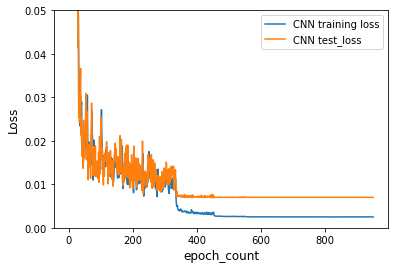

In [54]:
h_new = history_new.history

new_training_data = pd.DataFrame({"CNN training loss": h_new["loss"], "CNN test_loss": h_new["val_loss"]})
new_training_data.index.name = 'CNN Epoch'

fig_new = new_training_data.plot()
fig_new.set_xlabel(r'epoch_count', fontsize=12)
fig_new.set_ylabel(r'Loss', fontsize=12)
fig_new.set_ylim(0, 0.05)

y = model_new.predict(X_val_N)
print('max error:', np.max(np.abs(y - Y_val)))
print('mean absolute error:', np.mean(np.sqrt((y - Y_val) ** 2)))


## Fine tuning

Load and train

In [55]:
pretrained_model_N = keras.models.load_model('model_pretrained.h5')
pretrained_model_N.compile(loss='mae', optimizer=keras.optimizers.Adam(),
                           metrics=['mae'])  #loss functions are given for two output neurons

Train

In [56]:
pretrained_model_N.compile(loss='mae', optimizer=keras.optimizers.Adam(), metrics=['mae'])
history_finetuned_cavity = pretrained_model_N.fit(X_train_N, Y_train, epochs=2000, validation_data=(X_val_N, Y_val), batch_size=32, callbacks=cb_list)

Epoch 1/2000
8/8 [==============================] - 1s 52ms/step - loss: 0.0453 - mae: 0.0453 - val_loss: 0.0276 - val_mae: 0.0276 - lr: 0.0010
Epoch 2/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0160 - val_mae: 0.0160 - lr: 0.0010
Epoch 3/2000
8/8 [==============================] - 0s 10ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0127 - val_mae: 0.0127 - lr: 0.0010
Epoch 4/2000
8/8 [==============================] - 0s 9ms/step - loss: 0.0154 - mae: 0.0154 - val_loss: 0.0125 - val_mae: 0.0125 - lr: 0.0010
Epoch 5/2000
8/8 [==============================] - 0s 8ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0126 - val_mae: 0.0126 - lr: 0.0010
Epoch 6/2000
8/8 [==============================] - 0s 9ms/step - loss: 0.0130 - mae: 0.0130 - val_loss: 0.0124 - val_mae: 0.0124 - lr: 0.0010
Epoch 7/2000
8/8 [==============================] - 0s 9ms/step - loss: 0.0115 - mae: 0.0115 - val_loss: 0.0121 - val_mae: 0.0121 - lr: 0.0

Training results

8/8 [==============================] - 0s 14ms/step
max error: 0.06027377788111281
mean absolute error: 0.00604682345566672


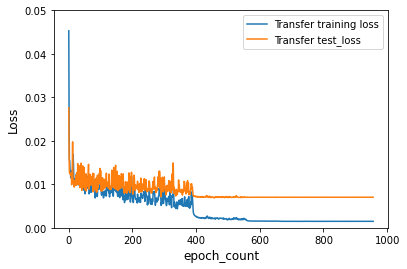

In [57]:
h_finetuned_cavity = history_finetuned_cavity.history
training_data_finetuned_cavity = pd.DataFrame(
    {"Transfer training loss": h_finetuned_cavity["loss"], "Transfer test_loss": h_finetuned_cavity["val_loss"]})
training_data_finetuned_cavity.index.name = 'Transfer Epoch'

fig_finetuned_cavity = training_data_finetuned_cavity.plot()
fig_finetuned_cavity.set_xlabel(r'epoch_count', fontsize=12)
fig_finetuned_cavity.set_ylabel(r'Loss', fontsize=12)
fig_finetuned_cavity.set_ylim(0, 0.05)

y = pretrained_model.predict(X_val)
print('max error:', np.max(np.abs(y - Y_val)))
print('mean absolute error:', np.mean(np.sqrt((y - Y_val) ** 2)))


# Combine with a denoiser

In [ ]:
from keras.models import load_model

filter_model = load_model('Training_data\with_noise\one_percent\model_denoise.h5')
tuned_cnn_model = load_model('Training_data\model_cavity_transfer.h5')
y = tuned_cnn_model.predict(X_val_N)
err = np.abs(Y_val - y)
err_df = pd.DataFrame({'W_par': err[:, 0], 'W_ort': err[:, 1]})
err_df.plot()

y_filtered = tuned_cnn_model.predict(filter_model.predict(X_val_N))
err_filtered = np.abs(Y_val - y_filtered)
err_filtered_df = pd.DataFrame({'W_par_filtered': err_filtered[:, 0], 'W_ort_filtered': err_filtered[:, 1]})
err_filtered_df.plot()

X_filtered = filter_model.predict(X_val_N)

index = 150
fig, ax = plt.subplots()
ax.plot(range(320), X_filtered[index, :, 0])
ax.plot(range(320), X_val_N[index, :, 0])
ax.legend(loc=0)